<a href="https://colab.research.google.com/github/cs23m066/DL-ASSIGNMENT/blob/main/DL_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback
import socket
socket.setdefaulttimeout(30)
wandb.login()
wandb.init(project ='DL_assignment')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs23m066 (dlassignment). Use `wandb login --relogin` to force relogin


In [4]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
train_images, validation_images,train_labels, validation_labels  = train_test_split(X_train,Y_train,test_size = 0.1)
#train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


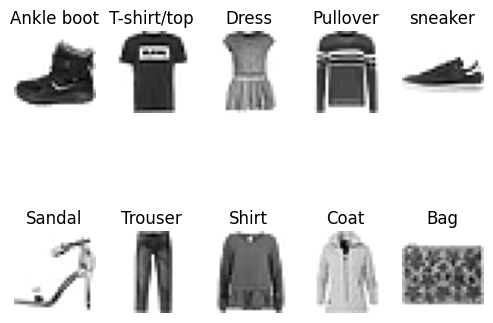

In [5]:
(train_images2, train_labels2), (test_images2, test_labels2) = fashion_mnist.load_data()
mySet = np.unique(train_labels2)
myData  = []
count = 10
for train_image,train_label in zip(train_images2,train_labels2):
  if(train_label in mySet ):
    index = np.where(mySet == train_label)
    myData.append(train_image)
    mySet = np.delete(mySet,index)
    count-=1
  if(count == 0):
    break
names =['Ankle boot','T-shirt/top','Dress','Pullover','sneaker','Sandal','Trouser','Shirt','Coat','Bag']
fig, axes = plt.subplots(2, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.set_title(names[i])
    ax.imshow(myData[i], cmap=plt.cm.binary)
    ax.axis('off')
plt.tight_layout()
#wandb.log({'plt':plt})
plt.show()

In [6]:
def _softmax(z):
  eps = 1e-6
  return (np.exp(z-max(z)) / (sum(np.exp(z-max(z))) + eps))

In [7]:
def _sigmoid(z):
  z = np.clip(z, -500, 500)
  return 1/(1+np.exp(-z))
  # return sigmoid_z

In [8]:
def _sigmoid_derivative(z):
  return _sigmoid(z) * (1 - _sigmoid(z))

In [9]:
def _tanh(z):
  clipped_z = np.clip(z, -50, 50)
  return np.tanh(clipped_z)

In [10]:
def _identity(z):
  return z

In [11]:
def _identity_derivative(z):
  res = np.ones(z.shape)
  return res

In [12]:
def _tanh_derivative(z):
  return 1-np.tanh(z)**2

In [13]:
def _relu(z):
  return np.maximum(0,z)

In [14]:
def _relu_derivative(z):
  return np.where(z>0,1,0)

In [15]:
def backwardPropogation(w,h,a,clas,n,train_image,activFunc,lossFun):
  dw = [0 for i in range(n+1)]
  db = [0 for i in range(n+1)]
  e_l = np.zeros((10,1))
  e_l[clas] = 1  # ([0,1,0,0,0,0,0,0,0,0])
  if(lossFun == 'entropy'):
    da = -(e_l - h[n])
  else :
    da = (h[n]-e_l)*(h[n])*(1-h[n])
  layers = len(w)-1
  while(layers>0):
    dw[layers] = np.matmul(da,(h[layers-1].T))
    db[layers] = np.copy(da)
    dh_n_1 = np.matmul((w[layers].T),da) #it will be used for and in below step only
    if(activFunc == 'sigmoid'):
      da = np.multiply(dh_n_1,_sigmoid_derivative(a[layers-1])) #for next iteration
    elif(activFunc == 'tanh'):
      da = np.multiply(dh_n_1,_tanh_derivative(a[layers-1]))
    elif(activFunc == 'relu'):
      da = np.multiply(dh_n_1,_relu_derivative(a[layers-1]))
    else:
      da = np.multiply(dh_n_1,_identity_derivative(a[layers-1]))
    layers-=1
  dw[0] = np.matmul(da,train_image.T)
  db[0] = np.copy(da)
  return dw,db

In [16]:
import copy

In [17]:
def forwardPropogation(w,b,n,train_image,activFunc):
  a = [0 for i in range(n+1)]
  h = [0 for i in range(n+1)]
  for i in range(0,n):
    if(i == 0 ):
      a[i] = np.matmul(w[i], train_image) + b[i]
    else:
      a[i] = np.matmul(w[i],h[i-1]) + b[i]
    if(activFunc == 'sigmoid'):
      h[i] = _sigmoid(a[i])
    elif(activFunc == 'tanh'):
      h[i] = _tanh(a[i])
    elif(activFunc == 'relu'):
      h[i] = _relu(a[i])
    else:
      h[i] = _identity(a[i])
  a[n] =  np.matmul(w[n],h[n-1]) + b[n]
  h[n] = np.copy(_softmax(a[n]))
  return a,h

In [18]:
def accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun):
  a,h = forwardPropogation(w,b,n,train_image,activFunc)
  res = np.copy(h[n])
  maxi = res[0]
  label = 0
  for i in range(1,10):
    if(res[i] > maxi ):
      maxi = res[i]
      label = i
  if(lossFun == 'entropy'):
    return label , -np.log(res[train_label]+(1e-5))
  else:
    a_l = np.zeros((10,1))
    a_l[train_label] = 1
    return label, np.sum((h[n]-a_l)**2)


In [19]:
def validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun):
  a,h = forwardPropogation(w,b,n,validation_image,activFunc)
  res = np.copy(h[n])
  maxi = res[0]
  label = 0
  for i in range(1,10):
    if(res[i] > maxi ):
      maxi = res[i]
      label = i
  if(lossFun == 'entropy'):
    return label,-np.log(res[validation_label]+(1e-5))
  else:
    a_l = np.zeros((10,1))
    a_l[validation_label] = 1
    return label, np.sum((h[n]-a_l)**2)

In [20]:
def intializer(n,neurons,weightInit):
  w = []
  b = []
  prev = 784
  if(weightInit == 'random'):
    for i in range (0,n):
      w.append(np.random.randn(neurons,prev))
      b.append(np.random.randn(neurons,1))
      prev = neurons
    w.append(np.random.randn(10,prev))
    b.append(np.random.randn(10,1))  #[(100,1),(100,1),(10,1)]
    # Weights are intitialzed  [(100,784),(100,100),(10,100)]
  else:
    for i in range (0,n):
      w.append(np.random.randn(neurons,prev))
      b.append(np.zeros((neurons,1)))
      prev = neurons
    w.append(np.random.randn(10,prev))
    b.append(np.zeros((10,1)))  #[(100,1),(100,1),(10,1)]
  return w,b

In [21]:
def SGD(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc,lossFun):
  t = 0
  w,b = intializer(n,neurons,weightInit)
  # biases are initiailzed
  count = 0
  while(t < maxIter):
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc,lossFun) # here 1 is class label
      for i in range(0,n+1):
        w[i] = w[i] - (learnRate) * ( dw[i]) - (weightDecay * w[i])
        b[i] = b[i] - (learnRate)* ( db[i])
    wandb.log({'epoch':t})
    t+=1
    count=0
    total_acE = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      label , cE = accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun)
      if( label == train_label):
          count+=1
      total_acE += cE
    print("train_accuracy","train_loss",count/540,total_acE/54000)
    wandb.log({'train_accuracy':count/540})
    wandb.log({'train_loss':total_acE/ 54000})
    validationAcc = 0
    total_vcE = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label_v,vE = validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun)
      if( label_v == validation_label):
        validationAcc +=1
      total_vcE += vE
    print("validation_accuracy","validation_loss",validationAcc/60,total_vcE/6000)
    wandb.log({'validation_accuracy':validationAcc/60})
    wandb.log({'validation_loss':total_vcE/6000})

  return count

In [22]:
def MGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun):
  w,b = intializer(n,neurons,weightInit)
  #ddw,ddb,pr_uw,pr_ub = init2(n,neurons)
  pr_uw = [0 for i in range(0,n+1)]
  pr_ub = [0 for i in range(0,n+1)]
  eta = learnRate
  beta = 0.9
  t = 0
  while(t < maxIter):

    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image2 = train_image.reshape(784,1) / 255
      a,h = forwardPropogation(w,b,n,train_image2,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image2,activFunc,lossFun)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          uw =  ddw[i] + (beta * pr_uw[i])
          ub =  ddb[i] + (beta * pr_ub[i])
          w[i] = (w[i] -  (eta * uw) - (weightDecay * w[i]))
          b[i] = (b[i] -  (eta * ub))
          pr_uw[i] = np.copy(uw)
          pr_ub[i] = np.copy(ub)
          for dddw in ddw:
            dddw[:] = 0
          for dddb in ddb:
            dddb[:] = 0
      temp+=1
    wandb.log({'epoch':t})
    t+=1
    count=0
    total_acE = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      label , cE = accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun)
      if( label == train_label):
          count+=1
      total_acE += cE
    print("train_accuracy","train_loss",count/540,total_acE/54000)
    wandb.log({'train_accuracy':count/540})
    wandb.log({'train_loss':total_acE/ 54000})
    validationAcc = 0
    total_vcE = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label_v,vE = validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun)
      if( label_v == validation_label):
        validationAcc += 1
      total_vcE += vE
    print("validation_accuracy","validation_loss",validationAcc/60,total_vcE/6000)
    wandb.log({'validation_accuracy':validationAcc/60})
    wandb.log({'validation_loss':total_vcE/ 6000})

  return count


In [23]:
def NGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun):
  w,b = intializer(n,neurons,weightInit) #initialization
  pr_uw = [0 for i in range(0,n+1)] #history
  pr_ub = [0 for i in range(0,n+1)]
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)] # these is for advance leap
  eta = learnRate
  beta = 0.9
  t = 0
  while(t < maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    dummy_w = [0 for i in range(0,n+1)]
    dummy_b = [0 for i in range(0,n+1)]
    for i in range(0,n+1):
      w[i] = w[i] - beta * pr_uw[i]
      b[i] = b[i] - beta * pr_ub[i]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc,lossFun)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          w[i] = w[i]- eta * ddw[i] - (weightDecay * w[i])
          b[i] = b[i] - eta * ddb[i]
          pr_uw[i] =   eta * ddw[i] + beta * pr_uw[i]
          pr_ub[i] =   eta * ddb[i] + beta * pr_ub[i]
        for dddw in ddw:
          dddw[:] = 0
        for dddb in ddb:
          dddb[:] = 0
      temp+=1
    wandb.log({'epoch':t})
    t+=1
    count=0
    total_acE = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      label , cE = accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun)
      if( label == train_label):
          count+=1
      total_acE += cE
    print("train_accuracy","train_loss",count/540,total_acE/54000)
    wandb.log({'train_accuracy':count/540})
    wandb.log({'train_loss':total_acE/ 54000})
    validationAcc = 0
    total_vcE = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label_v,vE = validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun)
      if( label_v == validation_label):
        validationAcc += 1
      total_vcE += vE
    print("validation_accuracy","validation_loss",validationAcc/60,total_vcE/6000)
    wandb.log({'validation_accuracy':validationAcc/60})
    wandb.log({'validation_loss':total_vcE/ 6000})
  return count


In [24]:
def rmsProp(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun):
  w,b = intializer(n,neurons,weightInit)
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)]
  eps = 1e-4
  t = 0
  beta = 0.5
  eta = learnRate
  while(t < maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc,lossFun)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          v_w[i] =  (1-beta)* (ddw[i] ** 2) + beta * v_w[i]
          v_b[i] =  (1-beta) * (ddb[i] ** 2) + beta * v_b[i]
          w[i] = w[i] - eta * ddw[i]/(np.sqrt(v_w[i])+eps) - (weightDecay * w[i])
          b[i] = b[i] - eta * ddb[i]/(np.sqrt(v_b[i])+eps)
          for dddw in ddw:
            dddw[:] = 0
          for dddb in ddb:
            dddb[:] =0
      temp+=1
    wandb.log({'epoch':t})
    t+=1
    count=0
    total_acE = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      label , cE = accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun)
      if( label == train_label):
          count+=1
      total_acE += cE
    print("train_accuracy","train_loss",count/540,total_acE/54000)
    wandb.log({'train_accuracy':count/540})
    wandb.log({'train_loss':total_acE/ 54000})
    validationAcc = 0
    total_vcE = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label_v,vE = validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun)
      if( label_v == validation_label):
        validationAcc += 1
      total_vcE += vE
    print("validation_accuracy","validation_loss",validationAcc/60,total_vcE/6000)
    wandb.log({'validation_accuracy':validationAcc/60})
    wandb.log({'validation_loss':total_vcE/ 6000})
  return count

In [25]:
def adam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun):
  w,b = intializer(n,neurons,weightInit)
  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-10
  eta = learnRate
  m_w = [0 for i in range(0,n+1)]
  m_b = [0 for i in range(0,n+1)]
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)]

  for iter in range (0,maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1) / 255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc,lossFun)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          m_w[i] = (1-beta1)*ddw[i] + beta1 * m_w[i]
          m_b[i] = (1-beta1)*ddb[i] + beta1 * m_b[i]
          v_w[i] = (1-beta2) * ddw[i]**2 + beta2 * v_w[i]
          v_b[i] = (1-beta2) * ddb[i]**2 + beta2 * v_b[i]
          #computed intermediate values
          m_w_hat = m_w[i] / (1-np.power(beta1,iter+1))
          m_b_hat = m_b[i] / (1-np.power(beta1,iter+1))
          v_w_hat = v_w[i] / (1-np.power(beta2,iter+1))
          v_b_hat = v_b[i] / (1-np.power(beta2,iter+1))
          #update parameters
          w[i] = w[i] - eta * m_w_hat / (np.sqrt(v_w_hat)+eps) - (weightDecay * w[i])
          b[i] = b[i] - eta* m_b_hat/ (np.sqrt(v_b_hat)+eps)
        for dddw in ddw:
          dddw[:] = 0
        for dddb in ddb:
          dddb[:] = 0
      temp+=1
    count=0
    total_acE = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      label , cE = accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun)
      if( label == train_label):
          count+=1
      total_acE += cE
    print("train_accuracy","train_loss",count/540,total_acE/54000)
    wandb.log({'train_accuracy':count/540})
    wandb.log({'train_loss':total_acE/ 54000})
    validationAcc = 0
    total_vcE = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label_v,vE = validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun)
      if( label_v == validation_label):
        validationAcc += 1
      total_vcE += vE
    print("validation_accuracy","validation_loss",validationAcc/60,total_vcE/6000)
    wandb.log({'validation_accuracy':validationAcc/60})
    wandb.log({'validation_loss':total_vcE/ 6000})
    wandb.log({'epoch':iter})
    #andb.log({"accuracy" : count/600})
  return count


In [26]:
def nadam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun):
  w,b = intializer(n,neurons,weightInit)
  eta = learnRate
  beta1 = 0.9
  beta2 = 0.99
  eps = 1e-10
  m_w = [0 for i in range(0,n+1)]
  m_b = [0 for i in range(0,n+1)]
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)]
  for iter in range(0,maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1) / 255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc,lossFun)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          m_w [i]= (1-beta1)*ddw[i] + beta1 * m_w[i]
          m_b[i] = (1-beta1)*ddb[i] + beta1 * m_b[i]
          v_w[i] = (1-beta2) * ddw[i]**2 + beta2 * v_w[i]
          v_b[i] = (1-beta2) * ddb[i]**2 + beta2 * v_b[i]
          #computed intermediate values
          m_w_hat = m_w[i] / (1-np.power(beta1,iter+1))
          m_b_hat = m_b[i] / (1-np.power(beta1,iter+1))
          v_w_hat = v_w[i] / (1-np.power(beta2,iter+1))
          v_b_hat = v_b[i] / (1-np.power(beta2,iter+1))
          #update parameters
          w[i] = w[i] - (eta / (np.sqrt(v_w_hat+eps)))*(beta1 * m_w_hat + (1-beta1)*ddw[i]/(1-beta1**(iter+1))) - (weightDecay * w[i])
          b[i] = b[i] - (eta / (np.sqrt(v_b_hat+eps)))*(beta1 * m_b_hat + (1-beta1)*ddb[i]/(1-beta1**(iter+1)))
        for dddw in ddw:
          dddw[:] = 0
        for dddb in ddb:
          dddb[:] = 0
      temp+=1
    count=0
    total_acE = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      label , cE = accuracyCalc(train_image,train_label,w,b,n,activFunc,lossFun)
      if( label == train_label):
          count+=1
      total_acE += cE
    print("train_accuracy","train_loss",count/540,total_acE/54000)
    wandb.log({'train_accuracy':count/540})
    wandb.log({'train_loss':total_acE/ 54000})
    validationAcc = 0
    total_vcE = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label_v,vE = validationAccuracy(validation_image,validation_label,w,b,n,activFunc,lossFun)
      if( label_v == validation_label):
        validationAcc += 1
      total_vcE += vE
    print("validation_accuracy","validation_loss",validationAcc/60,total_vcE/6000)
    wandb.log({'validation_accuracy':validationAcc/60})
    wandb.log({'validation_loss':total_vcE/ 6000})
    wandb.log({'epoch':iter})
  return w,b

In [27]:
def confusionMatrix(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun):
  w,b = nadam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun)
  predicted = []
  truth = []
  count = 0
  for X,Y in zip(X_test,Y_test):
    test_image = X.reshape(784,1)/255.0
    label , cE = accuracyCalc(test_image,Y,w,b,n,activFunc,lossFun)
    if(label == Y):
      count+=1
    predicted.append(label)
    truth.append(Y)
  print(count/100)
  cm = confusion_matrix(truth,predicted)
  plt.figure(figsize=(8, 6))
  sn.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix3')
  plt.savefig('confusion_matrix3.png')
  # Log the saved image using wandb
  wandb.log({"confusion_matrix3": wandb.Image('confusion_matrix3.png')})
  # Show the plot
  plt.show()


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [29]:
# maxIter = 2
# n = 3 # number of hidden layers
# neurons = 64 # size of every hidden layer
# weightDecay = 0
# learnRate = 0.001
# optimizer = 'sgd'
# batchSize = 100
# weightInit = 'random'
# activFunc = 'identity'
# lossFun = 'entropy'
# #accuracy = SGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun)
# #accuracy = MGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,lossFun)
# #accuracy = NGD(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
# #accuracy = rmsProp(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
# #accuracy = adam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc)
##nadam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc)
# #print(accuracy/600)
#confusionMatrix(3,128,5,0,0.001,64,'Xavier','sigmoid','entropy')


In [30]:
def mainFunction(maxIter,n,neurons,weightDecay,learnRate,optimizer,batchSize,weightInit,activFunc):
  if(optimizer == 'sgd'):
    accuracy = SGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,'entropy')
  elif(optimizer == 'mgd'):
    accuracy = MGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,'entropy')
  elif(optimizer == 'ngd'):
    accuracy = NGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,'entropy')
  elif(optimizer == 'rmsProp'):
    accuracy = rmsProp(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,'entropy')
  elif(optimizer == 'adam'):
    accuracy = adam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,'entropy')
  else:
    w,b = nadam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc,'entropy')


def main_fun():
  wandb.init(project ='DL_assignment')
  params = wandb.config
  with wandb.init(project = 'DL_assignment', name='optimizer_func '+params.optimizer+'weight_initial '+params.weightInit+'activation_func '+params.activFunc) as run:
    mainFunction(params.maxIter,params.n,params.neurons,params.weightDecay,params.learnRate,params.optimizer,params.batchSize,params.weightInit,params.activFunc)

#weightDecay is 0 now but change it later
sweep_params = {
    'method' : 'bayes',
    'name'   : 'Shriram',
    'metric' : {
        'goal' : 'maximize',
        'name' : 'validation_accuracy',
    },
    'parameters' : {
        'neurons':{'values':[64]},
        'optimizer':{'values':['sgd']},
        'maxIter' : {'values' : [5]},
        'n'       : {'values' : [3]},
        'weightDecay' : {'values' : [0] } ,
        'learnRate' : {'values' : [0.001]},
        'batchSize' : {'values' : [32]},
        'weightInit' : {'values': ['random']},
        'activFunc' : {'values' : ['sigmoid']}
    }
}
sweepId = wandb.sweep(sweep_params,project = 'DL_assignment')
wandb.agent(sweepId,function =main_fun,count = 1)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: z624jgum
Sweep URL: https://wandb.ai/dlassignment/DL_assignment/sweeps/z624jgum


wandb: Agent Starting Run: sripf9qr with config:
wandb: 	activFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	learnRate: 0.001
wandb: 	maxIter: 5
wandb: 	n: 3
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	weightDecay: 0
wandb: 	weightInit: random
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
Exception in thread   File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 268, in check_network_status
IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._loop_check_status(        
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


validation_accuracy validation_loss 69.08333333333333 [0.87753944]
validation_accuracy validation_loss 72.13333333333334 [0.75729944]
validation_accuracy validation_loss 74.0 [0.69809198]
validation_accuracy validation_loss 75.65 [0.66088634]
validation_accuracy validation_loss 76.48333333333333 [0.63447376]


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
validation_accuracy,▁▄▆▇█
validation_loss,█▅▃▂▁
epoch,4
train_accuracy,77.12037
train_loss,0.62619
validation_accuracy,76.48333
validation_loss,0.63447


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x794f5b3d6d10>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe